# Isolation by spatial random walks

Here I explore the isolation by resistence [[McRae 2006](https://github.com/jhmarcus/spatial-random-walk/tree/master/ref/mcrae_2006.pdf); [McRae 2007](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/mcrae_beier_2007.pdf)] approximation to expected genetic distances using simulations under the coalescent, following [[Petkova et al. 2016](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/petkova_et_al_2016.pdf)]. I also explore a recent development in the spatial statistics literature, which derives the induced covariance under a spatial-temporal random walk that can be implemented as a simultaneous auto-regressive process (SAR) [[Hanks 2016](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/hanks_2016.pdf)]. This framework allows for an analgous concept of resistence distance on directed graphs which could be of use for inference of asymetric migration in natural systems. See the `../ref` directory for a non-exhausitve list of other relevent papers on this topic.

# Background

## A simultaneous autogressive model for genotype data

Here we follow [[Hanks 2016](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/hanks_2016.pdf)] but switch up the notation a bit and gloss over most of the theoretical derivations. We also focus on large scale genotype data rather than using a SAR process as a random effect for microsatellite data. First, consider a single SNP $j$ with $\mathbf{y}_j$ carrying the mean centered genotypes of $n$ individuals. We define a dense regular lattice or graph $\mathcal{G}$ over geographic space. For simplicity, lets imagine we sample a single individual from every node on the graph. Let $\mathbf{M}$ be a $n \times n$ matrix storing the edge weights of $\mathcal{G}$. Note that because $\mathcal{G}$ is directed $\mathbf{M}$ is not necessarily symmetric. The exact structure of this lattice will determine what nodes are connected to each other and the magnitude of $m_{ij}$ is reflective of some migration process. In general $\mathbf{M}$  will be very sparse as nodes will only be connected to their neighbors. We define the typical SAR model for the observed genotypes ...


$$
\mathbf{y}_j = \rho\mathbf{W}\mathbf{y}_j + \mathbf{\nu} \\
$$

where $\mathbf{W}$ is the spatial weights matrix, $\rho$ is the autoregressive parameter and $\nu$ is a random effect with $\nu | \mathbf{\Lambda} \sim \mathcal{N}(\nu|\mathbf{0}, \mathbf{\Lambda})$ where $\mathbf{\Lambda}$ is a $n \times n$ diagonal matrix. We can simplify the above equation ...

$$
\mathbf{y}_j - \rho\mathbf{W}\mathbf{y}_j  = \mathbf{\nu} \\
(\mathbf{I} - \rho\mathbf{W})\mathbf{y}_j = \mathbf{\nu} 
$$

Thus as long as $(\mathbf{I} - \rho\mathbf{W})^{-1}$ exsists ...

$$
\mathbf{y}_j = (\mathbf{I} - \rho\mathbf{W})^{-1}\mathbf{\nu }
$$

then ...

$$
\mathbf{y}_j | \mathbf{W}, \mathbf{\Lambda} \sim \mathcal{N}\Big(\mathbf{y}_j | \mathbf{0}, (\mathbf{I} - \rho\mathbf{W})^{-1}\mathbf{\Lambda}(\mathbf{I} - \rho\mathbf{W}^T)^{-1} \big)
$$

If we let $\mathbf{B} = \rho\mathbf{W}$ and set ...

$$
b_{ij} = \frac{m_{ji}}{\sum_{k} m_{ik}} \\
\lambda_{ii} = \frac{1}{(\sum_{k} m_{ik})^2}
$$

then ...

$$
(\mathbf{L}\mathbf{L}^T)^{-1} = (\mathbf{I} - \mathbf{B})^{-1}\mathbf{\Lambda}(\mathbf{I} - \mathbf{B}^T)^{-1} \Rightarrow \\
\mathbf{L}\mathbf{L}^T = (\mathbf{I} - \mathbf{B}^T)\mathbf{\Lambda}^{-1}(\mathbf{I} - \mathbf{B})
$$

where $\mathbf{L}$, the graph laplacian of $\mathcal{G}$, can also be written as $\mathbf{L} = \mathbf{D} - \mathbf{M}$ with $\mathbf{D}$ being $n \times n$ diagonal matrix where $d_{ii} = \sum_{k \neq i} m_{ik}$. All of this implies that ...

$$
\mathbf{y}_j | \mathbf{L} \sim \mathcal{N}\big(\mathbf{y}_j | \mathbf{0}, (\mathbf{L}\mathbf{L}^T)^{-1}\big)
$$

We can compute an analogous idea of resistence distance for a directed graph using the covariance defined in the above model. If we let $\mathbf{1}$ be a column vector of size $n$ and $\mathbf{\Sigma} = (\mathbf{L}\mathbf{L}^T)^{-1}$ ...

$$
\tilde{\mathbf{R}} = \mathbf{1}diag(\mathbf{\Sigma})^T + diag(\mathbf{\Sigma})\mathbf{1}^T - 2\mathbf{\Sigma} 
$$

Note that the typical resistence distance for the undirected graph would be computed as ...

$$
\mathbf{R} = \mathbf{1}diag(\mathbf{L})^T + diag(\mathbf{L})\mathbf{1}^T - 2\mathbf{L} 
$$

# Simulations

## Imports / Configuration

Import standand libraries as well as some scripts in `../scripts` that have defined helper function to setup the habitat and simulate data under the coalescent given a habitat

In [2]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import laplacian
from scipy.linalg import pinv
import pickle as pkl
import os

# import helper functions for this notebook see ../scripts
import sys
sys.path.append('../scripts/')
from define_habitat import gen_lattice, quadratic_barrier_weights
from simulate_genotypes import stepping_stone

In [3]:
sns.set_style('white')
plt.style.use('bmh')
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = 8, 6

## Helper functions

In [4]:
def node_to_obs_mat(x, n, v):
    '''
    Converts node level array to data level array
    
    Args:
        x: np.array
            array at the level of nodes
        n: int
            number of observations
        v: np.array
            array carraying the node ids for each
            observation
    Returns:
        y: np.array
            array at the level of observations repeated
            from the node level array
    '''
    y = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            y[i,j] = x[v[i], v[j]]
            
    return(y)

def cov_to_dist(sigma):
    '''
    Converts covariance matrix to distance matrix
    
    Args:
        sigma: np.array
            covariance matrix
    Returns:
        d: np.array
            distance matrix
    '''
    n = sigma.shape[0]
    ones = np.ones(n).reshape(n, 1)
    sigma_diag = np.diag(sigma).reshape(n, 1)
    d = ones.dot(sigma_diag.T) + sigma_diag.dot(ones.T) - (2. * sigma)

    return(d)

## Setup the habitat

Here we simulate a habitat as a $8 \times 8$ triangular lattice $\mathcal{G}$. To simulate a barrier we define a quadratic function $f(s)$ of the spatial positions $s$ of each node. $f(s)$ is minimized at the middle of the barrier and the barrier is always set in the center of the habitat. We will consider different migration patterns later.

In [5]:
n = 8 # number of rows in lattice
p = 8 # number of cols in lattice
d = n * p # number of demes
lattice_dict = gen_lattice(n, p)
g = lattice_dict['g'] # the graph obj
s = lattice_dict['s'] # spatial positions
v = lattice_dict['v'] # node ids
pos_dict = lattice_dict['pos_dict']
m_min = .01 # max migration level
m_max = 3. # min migration level
g = quadratic_barrier_weights(g, s, m_min, m_max) # add weights to graph from quadratic
weights = [g[i][j]['m'] for i,j in g.edges()]

The triangular lattice is visualized with edge widths proportional to the defined edge weights, note we multiply the weights by some constant just for visualization purposes. Additional the nodes have a color scheme based on their position on the map, particularly the x position difference is emphasized more than the y.

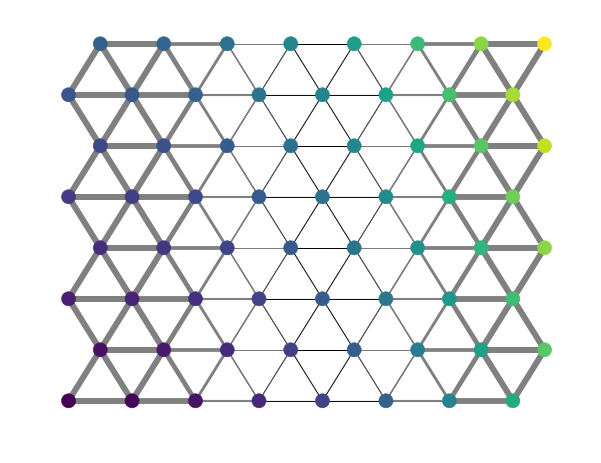

In [6]:
nx.draw(g, pos=pos_dict, node_size=200, node_color=s[:,0]**2 + (np.sqrt(d) / 2) * s[:,1], cmap=cm.viridis)  
nx.draw_networkx_edges(g, pos_dict, width=2*np.array(weights), edge_color='gray')

Extract the migration matrix $\mathbf{M}$ which stores all the edge weights in $\mathcal{G}$

In [7]:
m = nx.adjacency_matrix(g, weight='m')
m = m.toarray()
d = m.shape[0]

As expected we see that the migration matrix $\mathbf{M}$ is extremley sparse as only neighboring nodes are connected

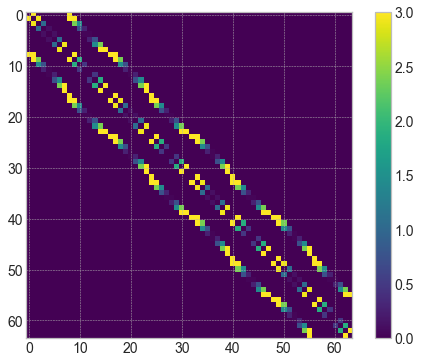

In [8]:
plt.imshow(m, cmap=cm.viridis)
plt.colorbar()

## Simulate genotypes

Here we simulate genotypes under the coalescent using [msprime](https://github.com/jeromekelleher/msprime) ... this may take a bit of time. Specifically we simulate 10 haploid individuals per deme in 5000 indepedent regions of the genome. See `../scripts/simulate_genotypes` for default parameters

In [9]:
%%time
path = '../output/y_barrier_stepping_stone.pkl'
if os.path.exists(path):
    with open(path, 'rb') as geno:
        y = pkl.load(geno)
else:
    with open(path, 'wb') as geno:
        y = stepping_stone(m, n_rep=5000, n=10)
        pkl.dump(y, geno)

CPU times: user 3.62 ms, sys: 14.8 ms, total: 18.5 ms
Wall time: 29.1 ms


In [10]:
# number simulated of haploid individuals and snps
n, p = y.shape 
print(n, p)

640 10522


Extract individual positions, demes, and migration rates

In [11]:
v_obs = np.repeat(v, int(n / d)).T
s_obs = np.vstack([np.repeat(s[:,0], int(n / d)), np.repeat(s[:,1], int(n / d))]).T
m_obs = node_to_obs_mat(m, n, v_obs)

Here we visualize the site frequency spectrum which seems to follow the neutral expectation ... (before when I simulted fewer independent reigions it had an enrichment of common variants as expected). **TODO**: debug this

Text(0,0.5,'log(Count)')

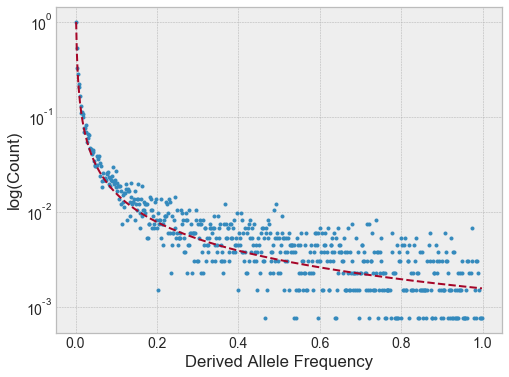

In [12]:
dac = np.sum(y, axis=0) 
x = np.arange(1, n) / n
sfs = np.histogram(dac, bins=np.arange(1, n + 1))[0]
plt.semilogy(x, sfs / sfs[0], '.')
plt.semilogy(x, 1 / (x * n), '--')
plt.xlabel('Derived Allele Frequency')
plt.ylabel('log(Count)')

Lets remove rare variants for subsequent visualization and distance computations

In [13]:
fil_idx = np.where(((dac / n) >= .05) & ((dac / n) <= .95))[0]
y = y[:,fil_idx]
p = float(y.shape[1])
print(n, p)

640 4738.0


Normalize the data for PCA

In [14]:
mu = np.mean(y, axis=0)
std = np.std(y, axis=0)
z = (y - mu) / std

Running PCA on the normalized genotype data, we see a strong signature of the barrier with two clusters based on geographic position on the x axis

Text(0,0.5,'PC2')

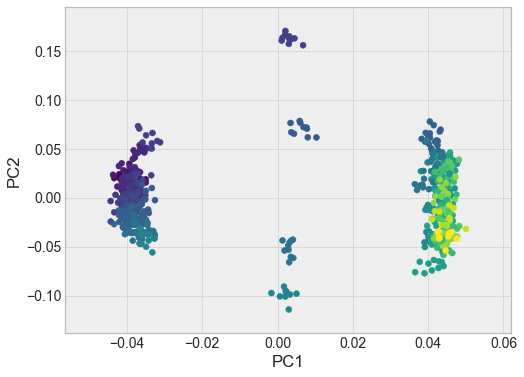

In [15]:
pca = PCA(n_components=5)
pca.fit(z.T)
pcs = pca.components_.T
plt.scatter(pcs[:,0], pcs[:,1], c=s_obs[:,0]**2 + (np.sqrt(d) / 2) * s_obs[:,1], cmap=cm.viridis)
plt.xlabel('PC1')
plt.ylabel('PC2')

## Computing distances

Compute the squred euclidian genetic distance using the mean centered genotypes

In [16]:
d_geno_obs = squareform(pdist((y - mu), metric='seuclidean')) / p

Compute the geographic distance based on the lattice $\mathcal{G}$ positions

In [17]:
d_geo_obs = squareform(pdist(s_obs, metric='seuclidean')) / 2

Compute the graph laplacian

In [18]:
l = np.diag(m.sum(axis=1)) - m

We can see the graph laplacian is sparse as $\mathbf{M}$ is sparse. We can think of $\mathbf{L}$ here as a sparse presicion matrix.

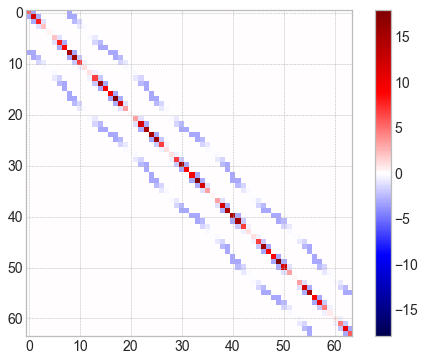

In [19]:
plt.imshow(l, cmap='seismic', norm=mpl.colors.Normalize(vmin=-np.max(l), vmax=np.max(l)))
plt.colorbar()

Compute the resistence distance $\mathbf{R}$

In [21]:
l_inv = pinv(l)
d_res = cov_to_dist(l_inv)
d_res_obs = node_to_obs_mat(d_res, n, v_obs)

Compute the random-walk distance $\tilde{\mathbf{R}}$ which we can see is also sparse but not as sparse. It seems to have an additional off-diagonal band.

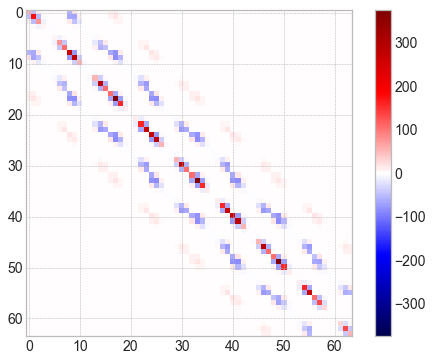

In [22]:
llt = l.dot(l.T)
plt.imshow(llt, cmap='seismic', norm=mpl.colors.Normalize(vmin=-np.max(llt), vmax=np.max(llt)))
plt.colorbar()

In [23]:
llt_inv = pinv(llt)
d_rw = cov_to_dist(llt_inv)
d_rw_obs = node_to_obs_mat(d_rw, n, v_obs)

Visualize the semivarigram for difference input distances

In [24]:
tri_idx = np.tril_indices(n, -1) # extract only lower tri of distance matrix
dist_df = pd.DataFrame({'Geographic Distance': d_geo_obs[tri_idx], 
                        'Genetic Distance': d_geno_obs[tri_idx],
                        'Resistence Distance': d_res_obs[tri_idx],
                        'Random Walk Distance': d_rw_obs[tri_idx]
                       })


r2 = 0.5674728750750556


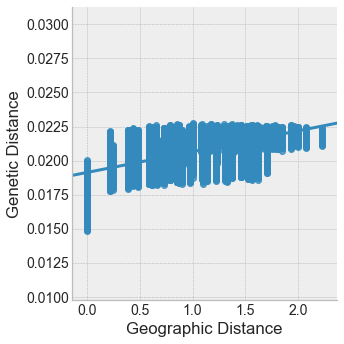

In [25]:
print('r2 = {}'.format(np.corrcoef(dist_df['Geographic Distance'], dist_df['Genetic Distance'])[0, 1]))
sns.lmplot(x='Geographic Distance', y='Genetic Distance', data=dist_df)

r2 = 0.7041919899166293


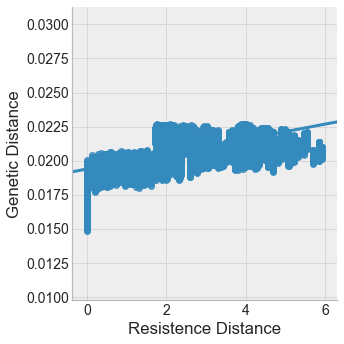

In [26]:
print('r2 = {}'.format(np.corrcoef(dist_df['Resistence Distance'], dist_df['Genetic Distance'])[0, 1]))
sns.lmplot(x='Resistence Distance', y='Genetic Distance', data=dist_df)

r2 = 0.9353953019540248


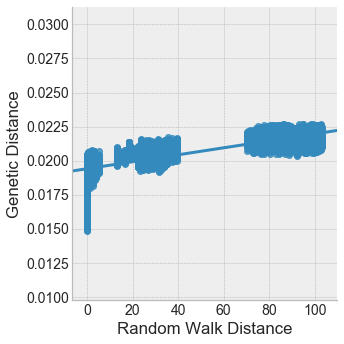

In [27]:
print('r2 = {}'.format(np.corrcoef(dist_df['Random Walk Distance'], dist_df['Genetic Distance'])[0, 1]))
sns.lmplot(x='Random Walk Distance', y='Genetic Distance', data=dist_df)

Text(0,0.5,'Count')

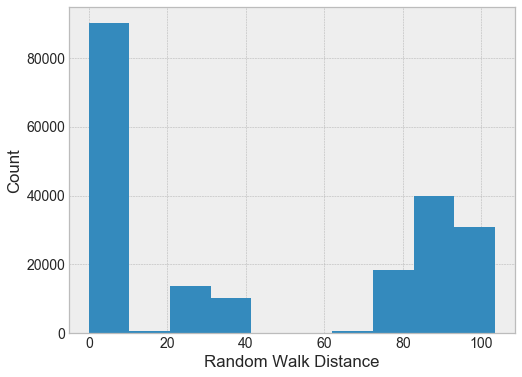

In [28]:
plt.hist(dist_df['Random Walk Distance'])
plt.xlabel('Random Walk Distance')
plt.ylabel('Count')

We can see that the random-walk distance has the highest correlation with the genetic distance out of the 3 we compare here. It actually seems suprisingly high. Note that scale of the input distances would be different then the scale of genetic distance. We could add an additional variance parameter to scale the covariance matrix in the likelihood, which will be addressed when thinking about inference under this model. I don't have a good intution for why the correlation would be higher for the "Random Walk Distance" even when simulating under a habitat with an undirected graph. One interesting feature of the "Random Walk Distance" semivariogram is that there seems to be 3 strong modes in the distance. This could make sense given the lattice structure and the simulated migration rates i.e. there are distances to compare accross the barrier, within each region on either side of the barrier and within each deme?